In [1]:
from helpers import ImageManager
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
from sklearn import svm
from sklearn import mixture
from sklearn.metrics import confusion_matrix
import glob
from sklearn.decomposition import PCA

In [2]:
mng = ImageManager()
testing_images = mng.get_testing_images(color=cv2.COLOR_BGR2GRAY)
training_images = mng.get_training_images(color=cv2.COLOR_BGR2GRAY)
_, _ = mng.update_testing_bounds()
_, _ = mng.update_training_bounds()
testing_faces = mng.testing_faces
training_faces = mng.training_faces

In [3]:
def extract_face(img, bounds):
    """
    Function takes in an image and bounds dict and returns a face
    """
    min_x =  bounds["min_x"]
    max_x =  bounds["max_x"]
    min_y =  bounds["min_y"]
    max_y =  bounds["max_y"]
    return img[min_y:max_y, min_x:max_x]

In [4]:
# Number of Features/Eigenfaces used in PCA (optimized)
NC = 15

## Training Images

In [5]:
training_faces = []
for i in range(60):
    img = training_images[i]
    face = extract_face(img, training_bounds[i])
    face = cv2.resize(face, (128,128))
    training_faces.append(face)  

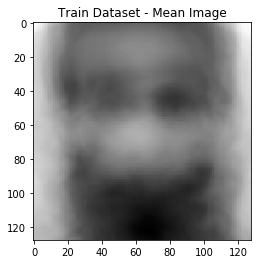

In [6]:
X_train = np.array([i.flatten() for i in training_faces])
pca = PCA(n_components=NC)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
plt.imshow(pca.mean_.reshape(training_faces[0].shape), cmap='gray')
plt.title('Train Dataset - Mean Image');

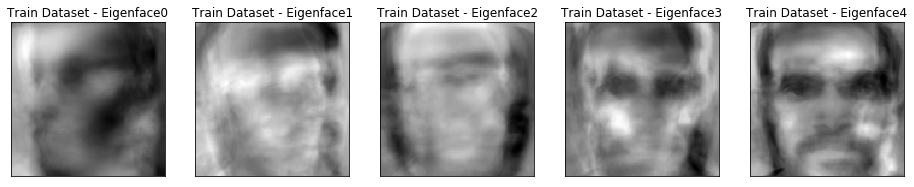

In [7]:
# Eigenfaces
fig = plt.figure(figsize=(16, 6))
for i in range(5):
    ax = fig.add_subplot(1, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape(training_faces[0].shape), 'gray')
    plt.title('Train Dataset - Eigenface{}'.format(i))

## Testing Images

In [8]:
# Adding the faces only to a list
testing_faces = []
for i in range(56):
    img = testing_images[i]
    face = extract_face(img, testing_bounds[i])
    face = cv2.resize(face, (128,128))
    testing_faces.append(face)

In [9]:
# Transforming test dataset using the trained PCA
X_test = np.array([i.flatten() for i in testing_faces])
X_test_pca = pca.transform(X_test)

In [10]:
# Creating labels for team members
labels = {0:'abdullah', 1:'mustafa', 2:'saleh', 3:'adham'}

# Creating correct labels for test set
y_test = np.array([[0]*14, [1]*14, [2]*14, [3]*14]).flatten()

# Creating correct labels for train set
y_train =  np.array([[0]*15, [1]*15, [2]*15, [3]*15]).flatten()

In [11]:
# List to hold 1 or 0 depending on predictions 
correct = []
for i, x_test in enumerate(X_test_pca):
    # Getting the index of the closest eigen face from the training set
    index = np.argmin(np.linalg.norm(X_test_pca[i]  - X_train_pca, axis=1))
    
    # Comparing the labels
    print('Predicted = {}\t|\tActual = {}'.format(labels[y_train[index]], labels[y_test[i]]))
    
    # Adding 1 to a list if prediction is correct
    correct.append(labels[y_train[index]] == labels[y_test[i]])


print('\nAccuracy = {:.3f}'.format(sum(correct)/len(X_test_pca)))

Predicted = abdullah	|	Actual = abdullah
Predicted = abdullah	|	Actual = abdullah
Predicted = mustafa	|	Actual = abdullah
Predicted = abdullah	|	Actual = abdullah
Predicted = mustafa	|	Actual = abdullah
Predicted = mustafa	|	Actual = abdullah
Predicted = adham	|	Actual = abdullah
Predicted = adham	|	Actual = abdullah
Predicted = mustafa	|	Actual = abdullah
Predicted = abdullah	|	Actual = abdullah
Predicted = abdullah	|	Actual = abdullah
Predicted = abdullah	|	Actual = abdullah
Predicted = abdullah	|	Actual = abdullah
Predicted = abdullah	|	Actual = abdullah
Predicted = mustafa	|	Actual = mustafa
Predicted = saleh	|	Actual = mustafa
Predicted = mustafa	|	Actual = mustafa
Predicted = saleh	|	Actual = mustafa
Predicted = mustafa	|	Actual = mustafa
Predicted = mustafa	|	Actual = mustafa
Predicted = mustafa	|	Actual = mustafa
Predicted = mustafa	|	Actual = mustafa
Predicted = mustafa	|	Actual = mustafa
Predicted = mustafa	|	Actual = mustafa
Predicted = mustafa	|	Actual = mustafa
Predicted =

## Number of Eigenfaces Optimization

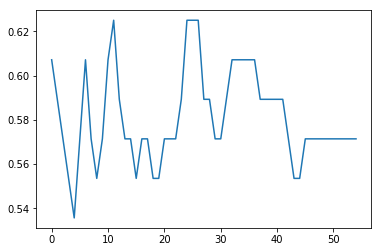

In [12]:
accuracies = []
for nc in np.linspace(4,60,55):
    nc = int(nc)
    pca = PCA(n_components=nc)
    pca.fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    # List to hold 1 or 0 depending on predictions 
    correct = []
    for i, x_test in enumerate(X_test_pca):
        # Getting the index of the closest eigen face from the training set
        index = np.argmin(np.linalg.norm(X_test_pca[i]  - X_train_pca, axis=1))

        # Adding 1 to a list if prediction is correct
        correct.append(labels[y_train[index]] == labels[y_test[i]])
    accuracies.append(sum(correct)/len(X_test_pca))
plt.plot(accuracies);

In [13]:
print('Best Value for NC = {:.0f}, with accuracy = {:.3f}'.format(
    np.linspace(4,60,55)[np.argmax(accuracies)], max(accuracies)))

Best Value for NC = 15, with accuracy = 0.625


In [16]:
np.array_equal(testing_images_new, testing_images)

True

In [18]:
np.array_equal(training_images_new, training_images)

True

In [20]:
np.array_equal(testing_bounds, tbn)

True

In [21]:
_, tbn = mng.update_training_bounds()
np.array_equal(training_bounds, tbn)

True

In [23]:
np.array_equal(mng.training_faces, training_faces)

True